In [64]:
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt
import math
import datetime
import time
import simpy
import opentnsim.core as core
import pyproj

# Compute the node coordinates
We'll create the node coordinates. Those can be used to create a table of nodes and we can connect them in a circle to create edges. Now we'll follow the approach numpy arrays -> 2 tables (nodes, edges) -> graph. We could also start with the graph, for example using `nx.circulant_graph`. 

In [2]:
# make nodes (12 nodes, like a clock)
n_nodes = 12
radians = np.linspace(0, np.pi * 2, num=12, endpoint=False)
r = 6 #radius of the cicle IRL
# coordinates for each node
x = r*np.cos(radians)
y = r*np.sin(radians)
lat = np.array([52.002240,52.002267,52.002287, 52.002294, 52.002287, 52.002267, 52.002240, 52.002213, 52.002193, 52.002186, 52.002193, 52.002213])
lon = np.array([4.371512,4.371501,4.371469, 4.371425, 4.371381, 4.371349, 4.371338, 4.371349, 4.371381, 4.371425, 4.371469, 4.371501])

x, y, lat, lon


(array([ 6.00000000e+00,  5.19615242e+00,  3.00000000e+00,  3.67394040e-16,
        -3.00000000e+00, -5.19615242e+00, -6.00000000e+00, -5.19615242e+00,
        -3.00000000e+00, -1.10218212e-15,  3.00000000e+00,  5.19615242e+00]),
 array([ 0.00000000e+00,  3.00000000e+00,  5.19615242e+00,  6.00000000e+00,
         5.19615242e+00,  3.00000000e+00,  7.34788079e-16, -3.00000000e+00,
        -5.19615242e+00, -6.00000000e+00, -5.19615242e+00, -3.00000000e+00]),
 array([52.00224 , 52.002267, 52.002287, 52.002294, 52.002287, 52.002267,
        52.00224 , 52.002213, 52.002193, 52.002186, 52.002193, 52.002213]),
 array([4.371512, 4.371501, 4.371469, 4.371425, 4.371381, 4.371349,
        4.371338, 4.371349, 4.371381, 4.371425, 4.371469, 4.371501]))

# Create the tables with nodes and edges
Create a table (dataframe) for both the nodes and the edges. Each row in the table is a node or an edge.

In [128]:
# Create a graph representing the pond
edges = []
nodes = []
# Loop over all the nodes
for i, (rad, x_i, y_i,lat_i,lon_i) in enumerate(zip(radians, x, y, lat, lon)):
    start = i
    # Are we at the end node?
    # then we need to close the loop
    if i == (n_nodes - 1):
        end = 0
    else:
        end = i + 1
        
    # an edge consists of a start node 
    edge = {
        "source": start, 
        "target": end,
        "e": (start, end),
        "rad": rad,
    }
    node = {
        "x": x_i,
        "y": y_i,
        "n": i,
        "lat": lat_i,
        "lon": lon_i,
        "geometry": shapely.geometry.Point(lon_i, lat_i),
    }
    edges.append(edge)
    nodes.append(node)
edges_df = pd.DataFrame(edges)
nodes_df = pd.DataFrame(nodes)
display(edges_df)
display(nodes_df)

,source,target,e,rad
0,0,1,"(0, 1)",0.000000
1,1,2,"(1, 2)",0.523599
2,2,3,"(2, 3)",1.047198
3,3,4,"(3, 4)",1.570796
4,4,5,"(4, 5)",2.094395
5,5,6,"(5, 6)",2.617994
6,6,7,"(6, 7)",3.141593
7,7,8,"(7, 8)",3.665191
8,8,9,"(8, 9)",4.188790
9,9,10,"(9, 10)",4.712389


,x,y,n,lat,lon,geometry
0,6.000000e+00,0.000000e+00,0,52.002240,4.371512,POINT (4.371512 52.00224)
1,5.196152e+00,3.000000e+00,1,52.002267,4.371501,POINT (4.371501 52.002267)
2,3.000000e+00,5.196152e+00,2,52.002287,4.371469,POINT (4.371469 52.002287)
3,3.673940e-16,6.000000e+00,3,52.002294,4.371425,POINT (4.371425 52.002294)
4,-3.000000e+00,5.196152e+00,4,52.002287,4.371381,POINT (4.371381 52.002287)
5,-5.196152e+00,3.000000e+00,5,52.002267,4.371349,POINT (4.371349 52.002267)
6,-6.000000e+00,7.347881e-16,6,52.002240,4.371338,POINT (4.371338 52.00224)
7,-5.196152e+00,-3.000000e+00,7,52.002213,4.371349,POINT (4.371349 52.002213)
8,-3.000000e+00,-5.196152e+00,8,52.002193,4.371381,POINT (4.371381 52.002193)
9,-1.102182e-15,-6.000000e+00,9,52.002186,4.371425,POINT (4.371425 52.002186)


# Geocode
We now have the geometry column for nodes. If we also add a geometry column to the edges table, then we can convert the table to a geodataframe so that we can use spatial operations (distances).  

,source,target,e,rad,geometry
0,0,1,"(0, 1)",0.000000,"LINESTRING (4.37151 52.00224, 4.37150 52.00227)"
1,1,2,"(1, 2)",0.523599,"LINESTRING (4.37150 52.00227, 4.37147 52.00229)"
2,2,3,"(2, 3)",1.047198,"LINESTRING (4.37147 52.00229, 4.37143 52.00229)"
3,3,4,"(3, 4)",1.570796,"LINESTRING (4.37143 52.00229, 4.37138 52.00229)"
4,4,5,"(4, 5)",2.094395,"LINESTRING (4.37138 52.00229, 4.37135 52.00227)"
5,5,6,"(5, 6)",2.617994,"LINESTRING (4.37135 52.00227, 4.37134 52.00224)"
6,6,7,"(6, 7)",3.141593,"LINESTRING (4.37134 52.00224, 4.37135 52.00221)"
7,7,8,"(7, 8)",3.665191,"LINESTRING (4.37135 52.00221, 4.37138 52.00219)"
8,8,9,"(8, 9)",4.188790,"LINESTRING (4.37138 52.00219, 4.37143 52.00219)"
9,9,10,"(9, 10)",4.712389,"LINESTRING (4.37143 52.00219, 4.37147 52.00219)"


<AxesSubplot: >

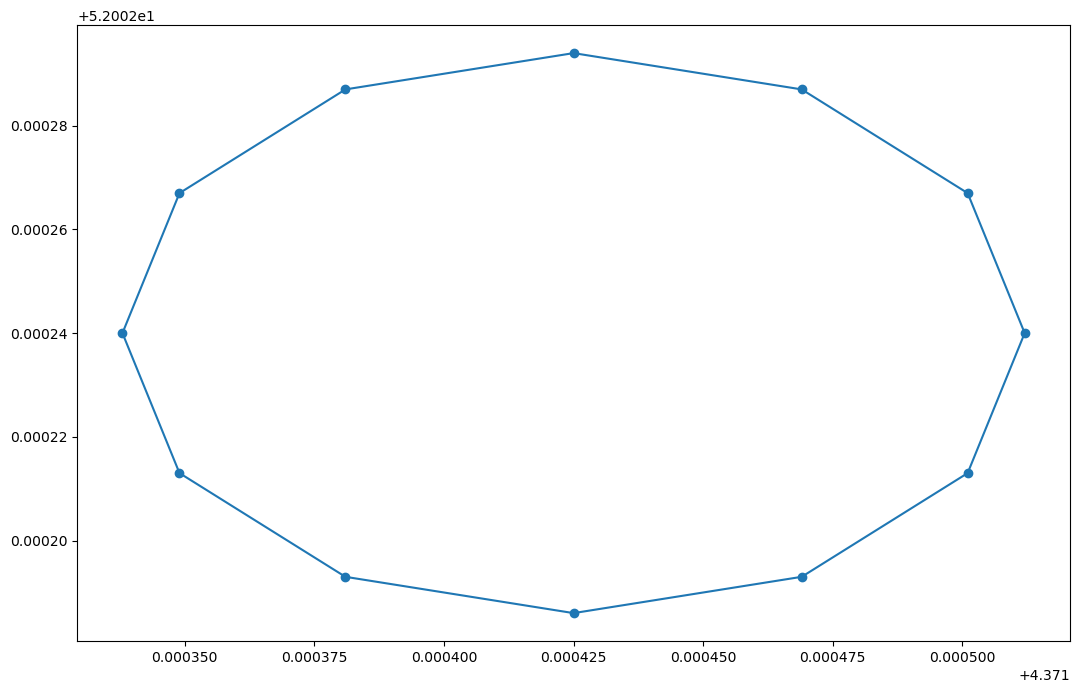

In [150]:
# the node

# create two temporary columns with the start end end geometry
edges_df['source_geometry'] = nodes_df['geometry'][edges_df['source']].reset_index(drop=True)
edges_df['target_geometry'] = nodes_df['geometry'][edges_df['target']].reset_index(drop=True)
# for each edge combine start and end geometry into a linestring (line)
edges_df['geometry'] = edges_df.apply(
    lambda row: shapely.geometry.LineString([row['source_geometry'], row['target_geometry']]), 
    axis=1
)
edges_df = edges_df.drop(columns=['source_geometry', 'target_geometry'])

nodes_gdf = gpd.GeoDataFrame(nodes_df)
edges_gdf = gpd.GeoDataFrame(edges_df)
nodes_gdf.set_crs("EPSG:4326", allow_override=True)
edges_gdf.set_crs("EPSG:4326", allow_override=True)
#edges_gdf["length_m"] = edges_gdf["geometry"].apply(lambda geom: geom.length)



display(edges_gdf)

# This is the spatial figure
fig, ax = plt.subplots(figsize=(13, 8))
edges_gdf.plot(ax=ax)
nodes_gdf.plot(ax=ax)

# Network
Now we can convert the nodes and edges into a networkx network.

In [151]:
# convention is that we call our graph FG (fairway graph)
FG = nx.from_pandas_edgelist(edges_gdf, edge_attr=True)

In [152]:
# update all nodes with info from the nodes table
nodes_gdf.apply(lambda row: FG.nodes[row.n].update(row), axis=1);

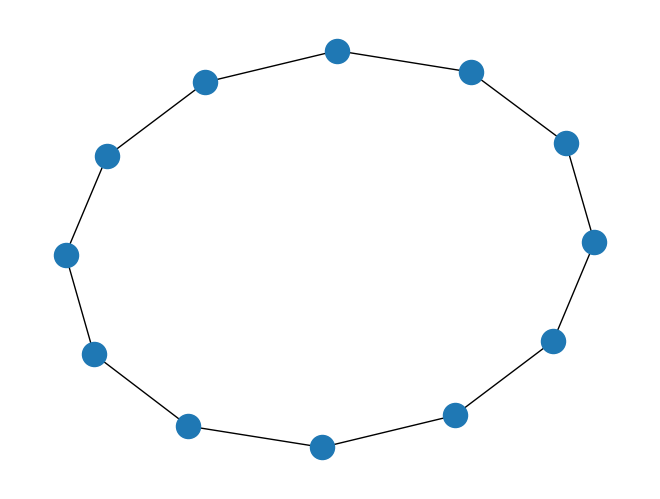

In [153]:
nx.draw(FG)

# Create Vessels

In [154]:
# Make a class out of mix-ins
TransportResource = type(
    'TransportResource', 
                         (core.Identifiable, core.Movable, 
                          core.HasResource, core.Routeable, core.HasContainer), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(4.37151, 52.00224),  # lon, lat
               "capacity": 1_000,
               "v": 1}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

# Define paths

In [155]:
path = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
print(path)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


# Run simulation

In [156]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        print(vessel.geometry)
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [157]:
print(vessel.geometry)

POINT (4.37151 52.00224)


In [158]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
vessel.env = env
vessel.route = path

# Start the simulation
env.process(start(env, vessel))
env.run()

print("Simulation of path {} took {} seconds".format(path, int(env.now - env.epoch)))

Origin POINT (4.37151 52.00224)
Destination POINT (4.371512 52.00224)
POINT (4.371501 52.002213)
Simulation of path [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] took 34 seconds


In [159]:
pd.DataFrame(vessel.log)


,Message,Timestamp,Value,Geometry
0,Start sailing,2022-10-31 14:31:18.000000,,POINT (4.37151 52.00224)
1,Sailing to start,2022-10-31 14:31:18.137349,0.137349,POINT (4.371512 52.00224)
2,Sailing from node 0 to node 1 start,2022-10-31 14:31:18.137349,0,POINT (4.371512 52.00224)
3,Sailing from node 0 to node 1 start,2022-10-31 14:31:21.235090,0,POINT (4.371501 52.002267)
4,Sailing from node 1 to node 2 start,2022-10-31 14:31:21.235090,0,POINT (4.371501 52.002267)
5,Sailing from node 1 to node 2 start,2022-10-31 14:31:24.362637,0,POINT (4.371469 52.002287)
6,Sailing from node 2 to node 3 start,2022-10-31 14:31:24.362637,0,POINT (4.371469 52.002287)
7,Sailing from node 2 to node 3 start,2022-10-31 14:31:27.483083,0,POINT (4.371425 52.002294)
8,Sailing from node 3 to node 4 start,2022-10-31 14:31:27.483083,0,POINT (4.371425 52.002294)
9,Sailing from node 3 to node 4 start,2022-10-31 14:31:30.603528,0,POINT (4.371381 52.002287)
